# To predict, we need data

### BCWS weather data lives in:
https://www.for.gov.bc.ca/ftp/HPR/external/!publish/BCWS_DATA_MART/

#### It wouldn't allow me to connect via FTP
So I just used Python's BeautifulSoup package to parse the HTML and grab the CSVs


In [2]:
from bs4 import BeautifulSoup
import pandas as pd
import requests

base_url = 'https://www.for.gov.bc.ca/'
bcws_data_mart = "ftp/HPR/external/!publish/BCWS_DATA_MART/2023"  # Replace this with the URL of the Apache page you want to scrape

csv_links = []

def get_links_from_apache_page(url):
    try:
        # Fetch the webpage content
        response = requests.get(url)
        response.raise_for_status()  # Raise an exception if there was an error in the request

        # Parse the HTML content using BeautifulSoup
        soup = BeautifulSoup(response.text, 'html.parser')

        # Find all anchor tags (<a>) to extract the links
        links = []
        for anchor in soup.find_all('a', href=True):
            link = anchor['href']
            if link.endswith('.csv'):
                csv_links.append(base_url + link)
            else:
                if not link.startswith('https://www.for.gov.bc.ca/'):
                    links.append(anchor['href'])
        
        for link in links:
            get_links_from_apache_page(base_url + bcws_data_mart + link)

    except requests.exceptions.RequestException as e:
        print("Error occurred during the request:", e)
        return None
    
if __name__ == "__main__":
    get_links_from_apache_page(base_url + bcws_data_mart)

    for csv in csv_links:
        df = pd.read_csv(csv)


Error occurred during the request: 404 Client Error: Not Found for url: https://www.for.gov.bc.ca/ftp/HPR/external/!publish/BCWS_DATA_MART/2023/ftp/HPR/external/!publish/BCWS_DATA_MART/


### BCWS fire data lives in the data mart

Brett pointed me to the bcdata Python package which grabs everything for us as geojson

We grab both the `current_fire_geojson` and `historical_fire_geojson` and merge them to give us the full history of BC fire incidents


In [4]:
import bcdata
import geopandas as gpd

current_fire_geojson = bcdata.get_data('fire-locations-current')

historical_fire_geojson = bcdata.get_data('fire-incident-locations-historical')

current_fire_gdf = gpd.GeoDataFrame.from_features(current_fire_geojson['features'])
historical_fire_gdf = gpd.GeoDataFrame.from_features(historical_fire_geojson['features'])
current_and_historical = gpd.GeoDataFrame.merge(current_fire_gdf, historical_fire_gdf, how='outer')

current_and_historical = current_and_historical.query('FIRE_CAUSE != "Nuisance Fire"')
current_and_historical

,geometry,FIRE_NUMBER,FIRE_YEAR,RESPONSE_TYPE_DESC,IGNITION_DATE,FIRE_OUT_DATE,FIRE_STATUS,FIRE_CAUSE,FIRE_CENTRE,ZONE,...,INCIDENT_NAME,GEOGRAPHIC_DESCRIPTION,LATITUDE,LONGITUDE,CURRENT_SIZE,FIRE_URL,FEATURE_CODE,OBJECTID,SE_ANNO_CAD_DATA,FIRE_LABEL
0,POINT (-121.75933 56.53283),G80609,2023,Full,2023-06-04Z,2023-06-04Z,Out,Person,4.0,8.0,...,None,Alexander Creek,56.5328,-121.7593,0.009,https://wildfiresituation.nrs.gov.bc.ca/incide...,JA70003000,1636948,NaN,NaN
1,POINT (-116.69552 51.70258),N40726,2023,Full,2023-06-10Z,2023-07-03Z,Out,Person,6.0,4.0,...,None,Wildcat Creek,51.7026,-116.6955,8.000,https://wildfiresituation.nrs.gov.bc.ca/incide...,JA70003000,1636949,NaN,NaN
2,POINT (-121.00392 51.77218),C40003,2023,Modified,2023-04-04Z,2023-04-12Z,Out,Person,7.0,4.0,...,C40003,N of Canim Hendrix Road,51.7722,-121.0039,0.009,https://wildfiresituation.nrs.gov.bc.ca/incide...,JA70003000,1636950,NaN,NaN
3,POINT (-119.60828 49.45630),K50004,2023,Full,2023-04-04Z,2023-04-13Z,Out,Person,5.0,5.0,...,None,South end of the KVR,49.4563,-119.6083,0.500,https://wildfiresituation.nrs.gov.bc.ca/incide...,JA70003000,1636951,NaN,NaN
4,POINT (-119.96812 50.86780),K20400,2023,Full,2023-05-19Z,2023-05-24Z,Out,Person,5.0,2.0,...,None,0.8 Km East of Louis Creek,50.8678,-119.9681,0.800,https://wildfiresituation.nrs.gov.bc.ca/incide...,JA70003000,1636952,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192103,POINT (-124.73333 52.38333),C50258,1999,None,1999-10-19Z,1999-11-02Z,NaN,Person,7.0,5.0,...,None,Satah Mtn,52.3833,-124.7333,1.000,NaN,JA70003000,951970,None,1999-C50258
192104,POINT (-124.02367 52.12767),C50261,1999,None,2000-03-06Z,2000-03-07Z,NaN,Person,7.0,5.0,...,None,4 East Redstone Reserve,52.1277,-124.0237,0.100,NaN,JA70003000,951971,None,1999-C50261
192105,POINT (-123.00000 52.26667),C50262,1999,None,2000-03-19Z,2000-03-21Z,NaN,Person,7.0,5.0,...,None,Anaham Reserve,52.2667,-123.0000,0.000,NaN,JA70003000,951972,None,1999-C50262
192106,POINT (-123.39000 52.09333),C50264,1999,Modified,2000-03-27Z,2000-03-30Z,NaN,Person,7.0,5.0,...,None,West side of Bull Canyon Park,52.0933,-123.3900,5.000,NaN,JA70003000,951973,None,1999-C50264


### We can then calculate aggregate results by year, like total fire count and area burned.

In [5]:
fires_per_year = current_and_historical.groupby('FIRE_YEAR').size().reset_index(name='annual_fire_count')
area_burned_per_year = current_and_historical.groupby('FIRE_YEAR')['CURRENT_SIZE'].sum().reset_index(name='area_burned')

aggregates_result = fires_per_year.merge(area_burned_per_year, on='FIRE_YEAR')
aggregates_result

,FIRE_YEAR,annual_fire_count,area_burned
0,1950,1436,343338.603
1,1951,1799,170081.101
2,1952,1739,61672.100
3,1953,1274,15703.400
4,1954,707,4213.200
...,...,...,...
69,2019,1868,21357.729
70,2020,1921,15559.967
71,2021,2993,869607.637
72,2022,3227,135304.806


In [7]:
from dateutil import parser
import pandas as pd
import matplotlib.pyplot as plt

# Convert the 'date_column' to datetime objects
gdf = current_and_historical
# gdf['IGNITION_DATE'] = pd.to_datetime(gdf['IGNITION_DATE'].str.rstrip('Z'), utc=True, errors='coerce')
gdf = gdf.set_index('IGNITION_DATE')
gdf.index

fires_by_week = gdf.resample('W').size().reset_index()
fires_by_week.columns = ['ignition_week', 'fire_count']
fires_by_week



,ignition_week,fire_count
0,1930-03-09 00:00:00+00:00,1
1,1930-03-16 00:00:00+00:00,0
2,1930-03-23 00:00:00+00:00,0
3,1930-03-30 00:00:00+00:00,0
4,1930-04-06 00:00:00+00:00,0
...,...,...
4871,2023-07-16 00:00:00+00:00,255
4872,2023-07-23 00:00:00+00:00,289
4873,2023-07-30 00:00:00+00:00,84
4874,2023-08-06 00:00:00+00:00,145


# Visualize the data
Let's look at the data before trying to play with it. Here's ignition starts by week across the whole BCWS history

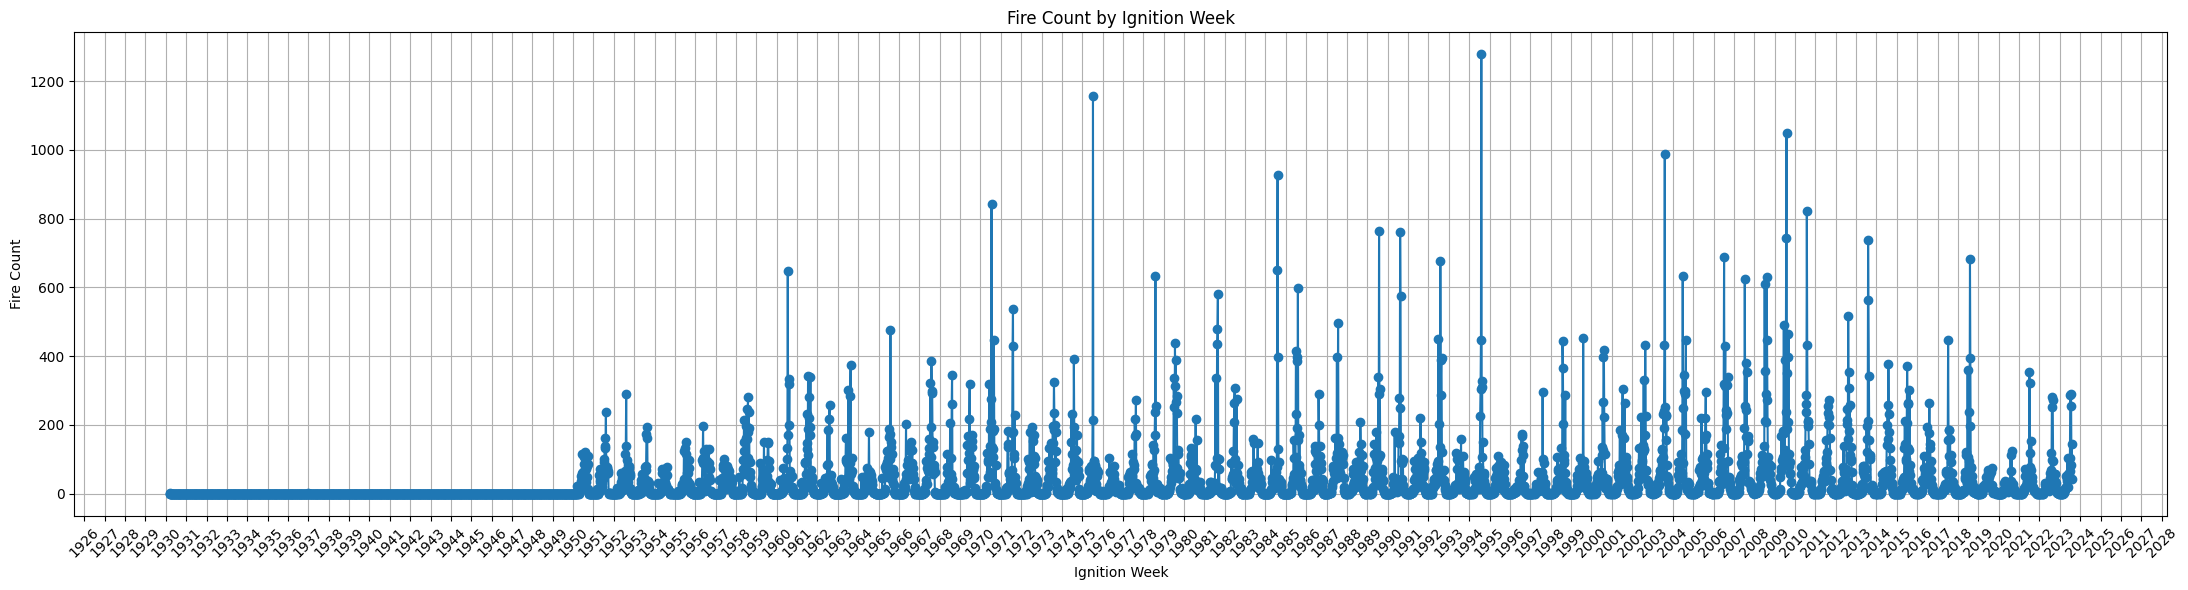

In [8]:
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, DateFormatter

fires_by_week['ignition_week'] = pd.to_datetime(fires_by_week['ignition_week'])

# Create the plot
plt.figure(figsize=(22, 6))  # Adjust the figure size if needed
plt.plot(fires_by_week['ignition_week'], fires_by_week['fire_count'], marker='o', linestyle='-')
plt.xlabel('Ignition Week')
plt.ylabel('Fire Count')
plt.title('Fire Count by Ignition Week')

# Show year labels
years = YearLocator()
year_format = DateFormatter('%Y')
plt.gca().xaxis.set_major_locator(years)
plt.gca().xaxis.set_major_formatter(year_format)

plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

# Start simple
Can we predict fire ignitions based on the geometry features that come out of the box?

1. Split the data up into train/test subsets based on the data being a timeseries
2. Try to fit the trained data to a linear function
3. Measure the accuracy

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split

tss = TimeSeriesSplit(n_splits = 3)

dataset = fires_by_week
dataset.dropna(inplace=True)
dataset['ignition_week'] = pd.to_numeric(pd.to_datetime(dataset['ignition_week']))


X = dataset.drop(labels=['fire_count'], axis=1)

y = dataset['fire_count']

for train_index, test_index in tss.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]



In [10]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

lr.fit(X_train, y_train)

print(lr.score(X_test, y_test))



-0.026891227451354638


Mean Squared Error: 12118.100579492459
R-squared: -0.026891227451354638


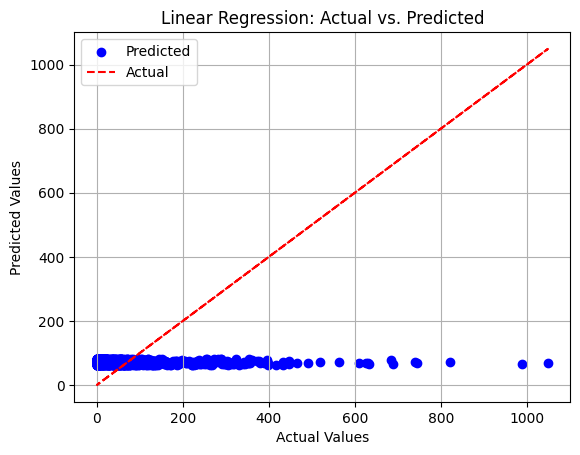

In [11]:

from sklearn.metrics import mean_squared_error, r2_score

y_pred = lr.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r_squared)

plt.scatter(y_test, y_pred, color='blue', label='Predicted')
plt.plot(y_test, y_test, color='red', linestyle='--', label='Actual')  # Plot the y = x line for reference
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Linear Regression: Actual vs. Predicted')
plt.legend()
plt.grid()
plt.show()


### It performs poorly. Back to the drawing board.

# Start simple -- refine
Can we extract and add day of the week to our data, and count ignitions per week to get a better prediction?

1. Split the data up into train/test subsets based on the data being a timeseries
2. Try to fit the trained data to a linear function
3. Measure the accuracy

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

data = current_and_historical
data = data.filter(['IGNITION_DATE', 'FIRE_OUT_DATE'])
data

# data['IGNITION_DATE'] = pd.to_datetime(data['IGNITION_DATE'].str.rstrip('Z'), utc=True, errors='coerce')
# data['FIRE_OUT_DATE'] = pd.to_datetime(data['FIRE_OUT_DATE'].str.rstrip('Z'), utc=True, errors='coerce')


# Feature Engineering: can we add day of the week to our data, and count ignitions per week to get a better prediction?
data['DAY_OF_WEEK'] = data['IGNITION_DATE'].dt.dayofweek

# Calculate the number of ignitions (fire incidents) for each record
data['NUM_IGNITIONS'] = 1

# Group by the date range (e.g., weekly) and count the number of ignitions in each group
timeframe = 'W'  # Choose the timeframe you want (e.g., 'W' for weekly, 'M' for monthly, etc.)
data_grouped = data.groupby(pd.Grouper(key='IGNITION_DATE', freq=timeframe)).sum()

# Merge the grouped data back to the original DataFrame
data = data.merge(data_grouped[['NUM_IGNITIONS']], left_on='IGNITION_DATE', right_index=True, suffixes=('', '_COUNT'))

# Step 4: Split the Data, try to predict by day of week
X = data.drop(['IGNITION_DATE', 'FIRE_OUT_DATE', 'NUM_IGNITIONS_COUNT'], axis=1)
y = data['NUM_IGNITIONS_COUNT']

X.dropna(inplace=True)
y = y[X.index]  # Align the target variable 'y' with the cleaned 'X' by selecting corresponding rows

X = dataset.drop(labels=['fire_count'], axis=1)

y = dataset['fire_count']

for train_index, test_index in tss.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Step 5: Model Selection (Random Forest Regressor)
model = LinearRegression()

# Step 6: Train the Model
model.fit(X_train, y_train)

# Step 7: Model Evaluation
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 12118.100579492459


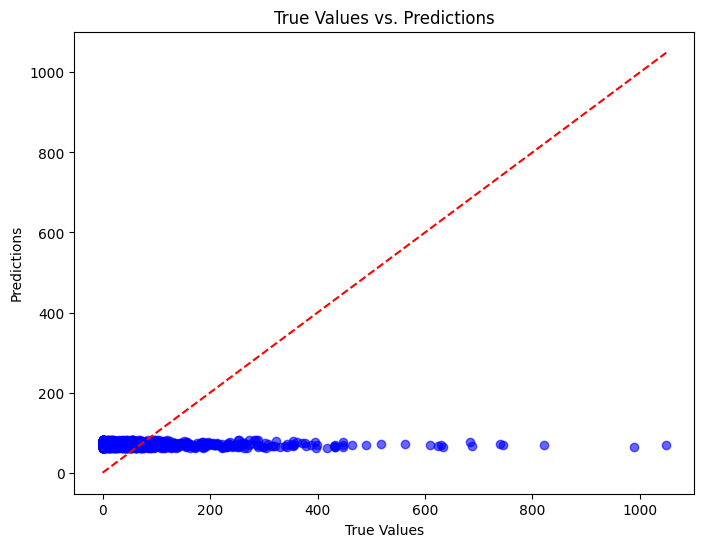

In [260]:
# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6)

# Add a line representing the perfect predictions (y = x)
max_value = max(max(y_test), max(y_pred))
plt.plot([0, max_value], [0, max_value], color='red', linestyle='--')

# Add labels and title
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True Values vs. Predictions')

plt.show()

### It performs poorly. Back to the drawing board.

# Start simple -- refine x2
Can we ignore the year and treat the data as purely seasonal to get a better prediction?

1. Split the data up into train/test subsets based on the data being a timeseries
2. Try to fit the trained data to a linear function
3. Measure the accuracy

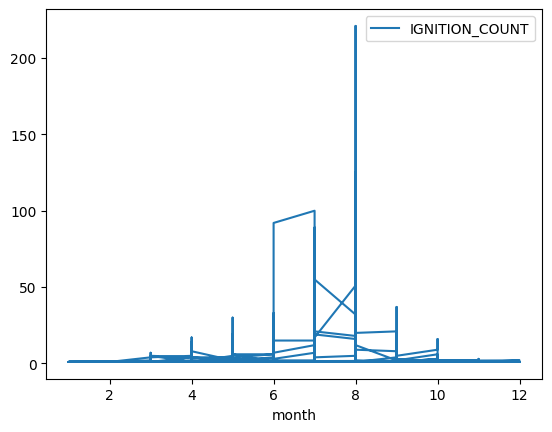

      day  month
0       8      8
1       9      8
2      10      8
3      11      8
4      12      8
...   ...    ...
1044    4      8
1045    5      8
1046    6      8
1047    7      8
1048    8      8

[1049 rows x 2 columns]
0        30
1        15
2        73
3       221
4        25
       ... 
1044     12
1045     25
1046     54
1047     31
1048     12
Name: IGNITION_COUNT, Length: 1049, dtype: int64
Mean Squared Error:  152.08201794568473


Text(0.5, 1.0, 'True Values vs. Predictions')

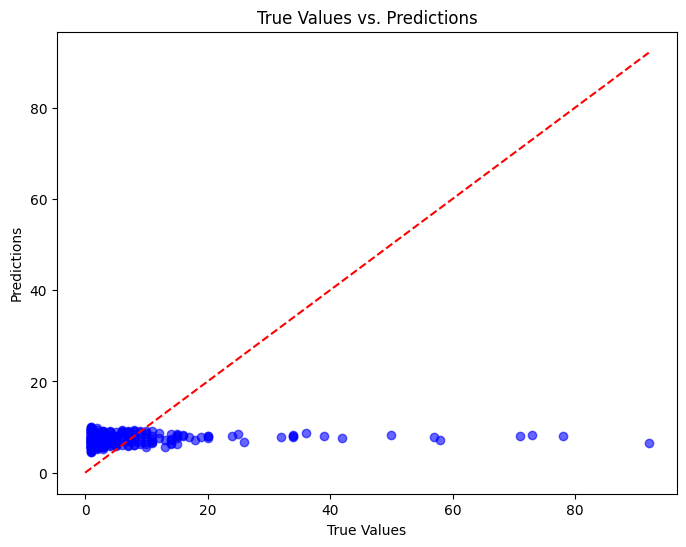

In [13]:
# Step 2: Feature Engineering, get ignition counts per day, try to predict with month and day as features
# Calculate the ignition count for each date (IGNITION_DATE)
ignition_counts_per_date = current_and_historical.groupby('IGNITION_DATE').size().reset_index(name='IGNITION_COUNT')
ignition_counts_per_date['IGNITION_DATE'] = pd.to_datetime(ignition_counts_per_date['IGNITION_DATE'])

recent_ignitions_per_date = ignition_counts_per_date[ignition_counts_per_date['IGNITION_DATE'] >= ignition_counts_per_date['IGNITION_DATE'].max() - pd.DateOffset(years=5)]
recent_ignitions_per_date.set_index('IGNITION_DATE', inplace=True)

# Create new columns for day and month, disregard year (seasonal)
recent_ignitions_per_date['day'] = recent_ignitions_per_date.index.day
recent_ignitions_per_date['month'] = recent_ignitions_per_date.index.month

# Step 3: Display the resulting table
seasonal_ignition_counts = recent_ignitions_per_date.reset_index(drop=True)
# seasonal_ignition_counts.plot.bar()


seasonal_ignition_counts.plot(x="month", y="IGNITION_COUNT")
plt.show()

seasonal_ignition_counts

X = seasonal_ignition_counts.drop(labels=['IGNITION_COUNT'], axis=1)
print(X)
y = seasonal_ignition_counts['IGNITION_COUNT']
print(y)

# using the train test split function
X_train, X_test, y_train, y_test = train_test_split(
  X,y , random_state=104,test_size=0.25, shuffle=True)


model = LinearRegression().fit(X_train,y_train)
y_pred = model.predict(X_test)
print("Mean Squared Error: ", mean_squared_error(y_test,y_pred))

# # Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6)

# Add a line representing the perfect predictions (y = x)
max_value = max(max(y_test), max(y_pred))
plt.plot([0, max_value], [0, max_value], color='red', linestyle='--')

# Add labels and title
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True Values vs. Predictions')

# plt.show()

### It performs poorly (but it is slighly more accurate!). Back to the drawing board.

# Start simple -- refine x3
Can we just consider the last 5 years of data

1. Split the data up into train/test subsets based on the data being a timeseries
2. Try to fit the trained data to a linear function
3. Measure the accuracy

Mean Squared Error: 334.64643827848124


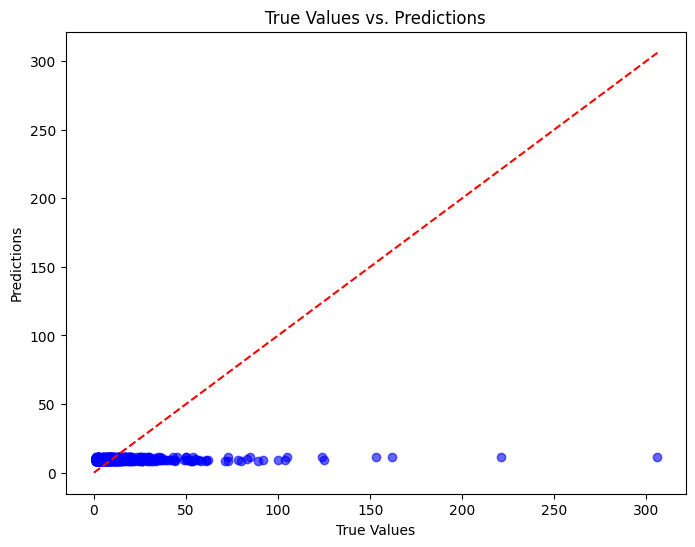

In [14]:

# Filter data for the last month
last_month_data = ignition_counts_per_date[ignition_counts_per_date['IGNITION_DATE'] >= ignition_counts_per_date['IGNITION_DATE'].max() - pd.DateOffset(years=20)]
last_month_data['IGNITION_DATE'] = pd.to_numeric(ignition_counts_per_date['IGNITION_DATE'])

tss = TimeSeriesSplit(n_splits = 3)


X = last_month_data.drop(labels=['IGNITION_COUNT'], axis=1)

y = last_month_data['IGNITION_COUNT']

for train_index, test_index in tss.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6)

# Add a line representing the perfect predictions (y = x)
max_value = max(max(y_test), max(y_pred))
plt.plot([0, max_value], [0, max_value], color='red', linestyle='--')

# Add labels and title
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True Values vs. Predictions')

plt.show()




### It performs poorly (and has regressed from last refinement1). Back to the drawing board.

## TODOs
- Merge fire weather data with historical/current fire incident data to aid in more detailed feature engineering
- Try different models
- Do more work on temporal/seasonal organization of data

In [231]:
weekly_counts = data.groupby(data['IGNITION_DATE'].dt.isocalendar().week)['NUM_IGNITIONS_COUNT'].sum().reset_index()
weekly_counts

# Determine the current week of the year
current_week = pd.Timestamp.now().isocalendar()[1]
current_week

# Calculate the absolute difference in weekly ignition count between each week and the current week
weekly_counts['DIFFERENCE'] = abs(weekly_counts['week'] - current_week)

# Sort the weeks based on the absolute difference in ascending order
weekly_counts.sort_values('DIFFERENCE', inplace=True)
weekly_counts

# # Get the top closest weeks to the current week based on week-by-week ignition count
# # top_closest_weeks = weekly_counts['week'].head(5).tolist()
# # top_closest_weeks

# # Get the top closest weeks to the current week based on week-by-week ignition count
# top_closest_weeks = weekly_counts.head(5)

# # Merge with the original 'data' DataFrame to get the timestamps of the top closest weeks
# merged_data = data.merge(top_closest_weeks, left_on=data['IGNITION_DATE'].dt.isocalendar().week, right_on='week', suffixes=('', '_COUNT'))
# merged_data

# print("Top closest weeks to the current week based on week-by-week ignition count:")
# print(merged_data[['IGNITION_DATE', 'NUM_IGNITIONS_COUNT_COUNT']])

,week,NUM_IGNITIONS_COUNT,DIFFERENCE
31,32,971571,0
32,33,541920,1
33,34,226373,2
34,35,123712,3
35,36,122617,4
36,37,59656,5
37,38,34525,6
38,39,17317,7
39,40,16420,8
40,41,9515,9
